# Programming with RDDs

#### Links

* https://spark.apache.org/docs/1.6.0/programming-guide.html#resilient-distributed-datasets-rdds
* https://spark.apache.org/docs/1.1.1/api/python/pyspark.rdd.RDD-class.html

In [1]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import os
import sys
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('./')

from utils import *


os.environ["PYSPARK_PYTHON"] = "/usr/bin/python3.5"

In [2]:
!spark-submit --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 1.6.0
      /_/
                        
Type --help for more information.


## Запускаем Spark

In [3]:
import pyspark
from pyspark.conf import SparkConf
from pyspark.sql import SQLContext


conf = SparkConf()
conf.setMaster("yarn-client")
conf.set("spark.executor.instances", "4")
conf.set("spark.executor.cores", "4") 
conf.set("spark.executor.memory", "4g")
conf.set("spark.core.connection.ack.wait.timeout", "1200")

# conf.set("spark.dynamicAllocation.enabled", "true")
# conf.set("spark.shuffle.service.enabled", "true")
# conf.set("spark.dynamicAllocation.initialExecutors", 2)
# conf.set("spark.dynamicAllocation.maxExecutors", 2)

sc = pyspark.SparkContext(conf = conf)
sc.addPyFile('./utils.py')
sqlContext = SQLContext(sc)

## Работа с hdfs

Утилитой командной строки -- `hdfs` (https://hadoop.apache.org/docs/current/hadoop-project-dist/hadoop-common/FileSystemShell.html)

Полезные команды:
* `hdfs dfs -ls [<path>]`
* `hdfs dfs -rm <path>`
* `hdfs dfs -mv <src> <dst>`
* `hdfs dfs -copyToLocal <src> <dst local>`
* `hdfs dfs -copyFromLocal <src local> <dst>`


### Копирование данных

Прежде чем начать работать с самим данными их нужно сохранить в hdfs.

1. Запустите terminal через Jupyter
2. `hdfs dfs -copyFromLocal data .`


Проверяем, что все данные на месте

In [4]:
!hdfs dfs -ls data/ml-25m/

Found 10 items
-rw-r--r--   1 root supergroup      10460 2020-02-03 10:16 data/ml-25m/README.txt
-rw-r--r--   1 root supergroup  435164157 2020-02-03 10:16 data/ml-25m/genome-scores.csv
-rw-r--r--   1 root supergroup      18103 2020-02-03 10:16 data/ml-25m/genome-tags.csv
-rw-r--r--   1 root supergroup    1368578 2020-02-03 10:16 data/ml-25m/links.csv
-rw-r--r--   1 root supergroup      12022 2020-02-03 10:16 data/ml-25m/ml-25m-README.htm
drwxr-xr-x   - root supergroup          0 2020-02-03 10:35 data/ml-25m/movie_avg_rating
-rw-r--r--   1 root supergroup    3038099 2020-02-03 10:16 data/ml-25m/movies.csv
-rw-r--r--   1 root supergroup  678260987 2020-02-03 10:16 data/ml-25m/ratings.csv
-rw-r--r--   1 root supergroup   38810332 2020-02-03 10:16 data/ml-25m/tags.csv
-rw-r--r--   1 root supergroup  404281742 2020-02-03 10:16 data/ml-25m/tmdb.json


### Чтение данных

*Замечание*: Файл `ml-25m-README.htm` содержит описание данных

In [5]:
DATA_PATH = 'data/ml-25m'

RATINGS_PATH = os.path.join(DATA_PATH, 'ratings.csv')
MOVIES_PATH = os.path.join(DATA_PATH, 'movies.csv')
TAGS_PATH = os.path.join(DATA_PATH, 'tags.csv')

In [6]:
ratings = sc.textFile(RATINGS_PATH)

In [7]:
ratings.take(5)

['userId,movieId,rating,timestamp',
 '1,296,5.0,1147880044',
 '1,306,3.5,1147868817',
 '1,307,5.0,1147868828',
 '1,665,5.0,1147878820']

In [8]:
ratings.getNumPartitions()

5

In [9]:
ratings = ratings \
    .map(lambda s: s.split(',')) \
    .filter(lambda arr: arr[0].isdigit()) \
    .map(lambda arr: Rating(user_id=int(arr[0]), 
                            movie_id=int(arr[1]), 
                            rating=float(arr[2]), 
                            timestamp=int(arr[3])))

In [10]:
ratings.count()

25000095

In [11]:
ratings.first().__dict__

{'movie_id': 296, 'rating': 5.0, 'timestamp': 1147880044, 'user_id': 1}

Количество пользователей

In [12]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 16.1 ms, sys: 12.7 ms, total: 28.8 ms
Wall time: 1min 4s


162541

Сохраним датасет в память

In [13]:
ratings = ratings.persist()

In [14]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 36.2 ms, sys: 2.29 ms, total: 38.5 ms
Wall time: 1min 49s


162541

Количество фильмов

In [15]:
ratings \
    .map(lambda r: r.movie_id)\
    .distinct()\
    .count()

59047

## Упражнения

### Фильмы с наибольшим средним рейтингом

Найти 10 фильмов с наибольшим средним рейтингом. Вывести их названия и средний рейтинг

In [16]:
movies = sc.textFile(MOVIES_PATH)
movies.take(5)

['movieId,title,genres',
 '1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy',
 '2,Jumanji (1995),Adventure|Children|Fantasy',
 '3,Grumpier Old Men (1995),Comedy|Romance',
 '4,Waiting to Exhale (1995),Comedy|Drama|Romance']

In [17]:
movies = movies \
    .map(lambda s: s.split(',')[:2]) \
    .filter(lambda arr: arr[0].isdigit()) \
    .keyBy(lambda arr: int(arr[0]))

movie_avg_rating = ratings \
    .map(lambda r: (r.movie_id, (r.rating, 1))) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
    .mapValues(lambda ratings: ratings[0] / ratings[1])

movie_avg_rating \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1][0], ascending=False)\
    .take(10)

[(196959, (5.0, ['196959', 'I Am JFK Jr. (2016)'])),
 (180663, (5.0, ['180663', '"Goodbye'])),
 (147966, (5.0, ['147966', "Tarzan's Fight for Life (1958)"])),
 (131628, (5.0, ['131628', 'Loaded (2014)'])),
 (131922, (5.0, ['131922', 'Private Duty Nurses (1971)'])),
 (188573, (5.0, ['188573', 'Judy (2014)'])),
 (164787, (5.0, ['164787', 'You Cast A Spell On Me (2015)'])),
 (132321, (5.0, ['132321', 'Black Oak Conspiracy (1977)'])),
 (165221, (5.0, ['165221', 'Elf Bowling the Movie (2007)'])),
 (149268, (5.0, ['149268', 'The Pied Piper (1942)']))]

Сохраните `rdd`, состоящий из строк вида `<movie_id>,<average_rating>` на hdfs в виде текстового файла

In [ ]:
movie_avg_rating\
    .repartition(10) \
    .saveAsTextFile(os.path.join(DATA_PATH, 'movie_avg_rating'))

In [19]:
! hdfs dfs -ls data/ml-25m/movie_avg_rating

Found 11 items
-rw-r--r--   1 root supergroup          0 2020-02-03 10:35 data/ml-25m/movie_avg_rating/_SUCCESS
-rw-r--r--   1 root supergroup      58903 2020-02-03 10:35 data/ml-25m/movie_avg_rating/part-00000
-rw-r--r--   1 root supergroup     112361 2020-02-03 10:35 data/ml-25m/movie_avg_rating/part-00001
-rw-r--r--   1 root supergroup     131524 2020-02-03 10:35 data/ml-25m/movie_avg_rating/part-00002
-rw-r--r--   1 root supergroup     114377 2020-02-03 10:35 data/ml-25m/movie_avg_rating/part-00003
-rw-r--r--   1 root supergroup     133576 2020-02-03 10:35 data/ml-25m/movie_avg_rating/part-00004
-rw-r--r--   1 root supergroup     117783 2020-02-03 10:35 data/ml-25m/movie_avg_rating/part-00005
-rw-r--r--   1 root supergroup     143242 2020-02-03 10:35 data/ml-25m/movie_avg_rating/part-00006
-rw-r--r--   1 root supergroup     131984 2020-02-03 10:35 data/ml-25m/movie_avg_rating/part-00007
-rw-r--r--   1 root supergroup     167729 2020-02-03 10:35 data/ml-25m/movie_avg_rating/part-000

### Популярность тэгов

Найти 20 наиболее популярных тэгов

In [20]:
tags = sc.textFile(TAGS_PATH)
tags.take(5)

['userId,movieId,tag,timestamp',
 '3,260,classic,1439472355',
 '3,260,sci-fi,1439472256',
 '4,1732,dark comedy,1573943598',
 '4,1732,great dialogue,1573943604']

In [21]:
tags_count = tags\
    .map(lambda s: (s.split(',')[2], 1))\
    .reduceByKey(lambda a, b: a + b)\
    .collect()

len(tags_count)

73016

In [22]:
tags_count = sorted(tags_count, key=lambda tag_count: tag_count[1], reverse=True)

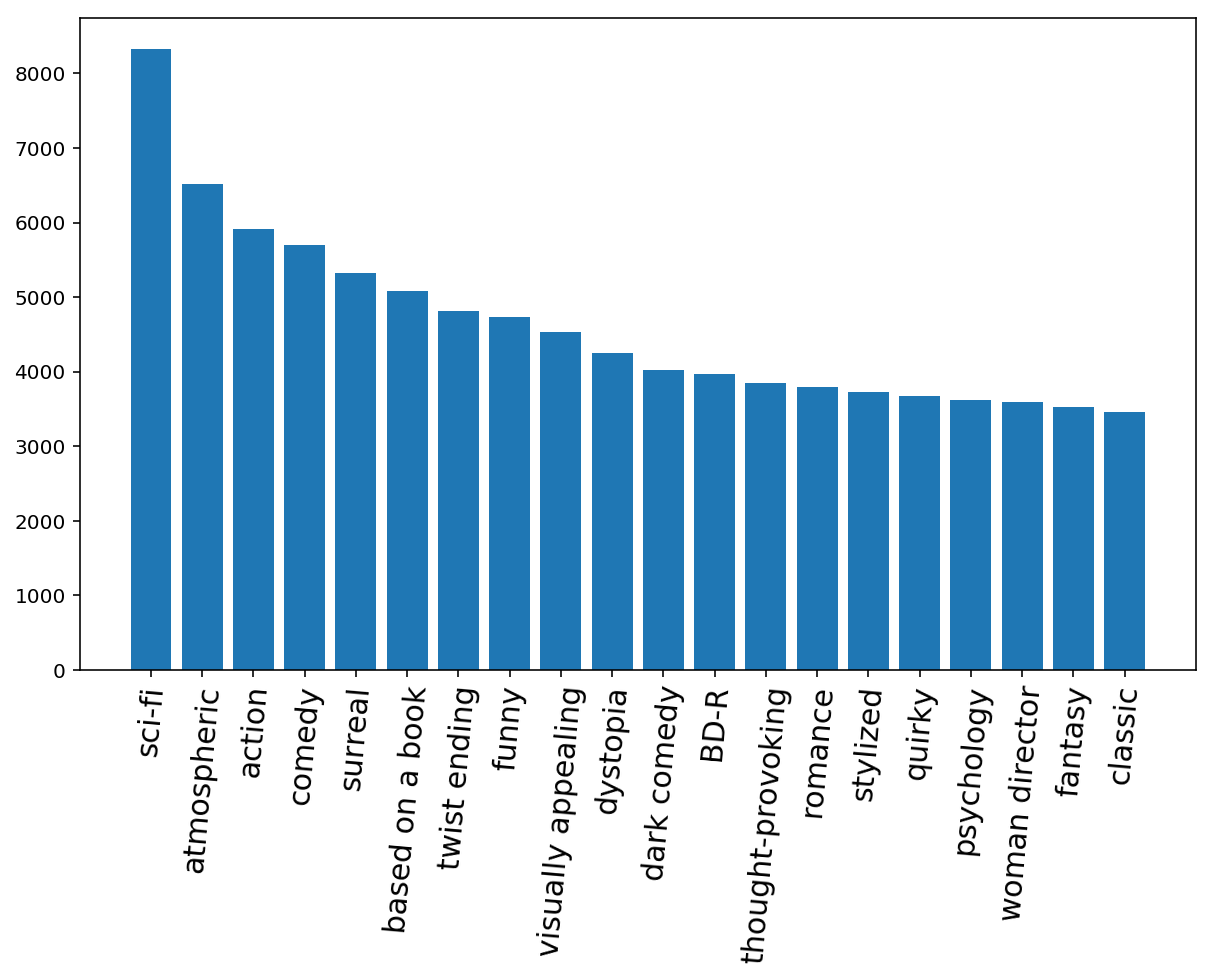

In [23]:
keys, values = zip(*tags_count[:20])

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys, values, align="center")
plt.show()

### Фильмы с наибольшим числом оценок

Найти 10 фильмов с наибольшим числом оценок. Вывести их названия и число оценок

In [24]:
movie_rating_count = ratings\
    .map(lambda r: (r.movie_id, 1))\
    .reduceByKey(lambda a, b: a + b)

movie_rating_count\
    .join(movies)\
    .sortBy(lambda key_value: key_value[1][0], ascending=False)\
    .take(10)

[(356, (81491, ['356', 'Forrest Gump (1994)'])),
 (318, (81482, ['318', '"Shawshank Redemption'])),
 (296, (79672, ['296', 'Pulp Fiction (1994)'])),
 (593, (74127, ['593', '"Silence of the Lambs'])),
 (2571, (72674, ['2571', '"Matrix'])),
 (260, (68717, ['260', 'Star Wars: Episode IV - A New Hope (1977)'])),
 (480, (64144, ['480', 'Jurassic Park (1993)'])),
 (527, (60411, ['527', "Schindler's List (1993)"])),
 (110, (59184, ['110', 'Braveheart (1995)'])),
 (2959, (58773, ['2959', 'Fight Club (1999)']))]

### Фильмы с наибольшим числом 5

Найти 10 фильмов с наибольшим числом 5ок в качестве оценки. Вывести их названия и число 5ок

In [25]:
movie_5_count = ratings\
    .filter(lambda r: r.rating == 5)\
    .map(lambda r: (r.movie_id, 1))\
    .reduceByKey(lambda a, b: a + b)

movie_5_count\
    .join(movies)\
    .sortBy(lambda key_value: key_value[1][0], ascending=False)\
    .take(10)

[(318, (39553, ['318', '"Shawshank Redemption'])),
 (296, (32169, ['296', 'Pulp Fiction (1994)'])),
 (356, (25918, ['356', 'Forrest Gump (1994)'])),
 (260, (25804, ['260', 'Star Wars: Episode IV - A New Hope (1977)'])),
 (2571, (25482, ['2571', '"Matrix'])),
 (527, (24853, ['527', "Schindler's List (1993)"])),
 (593, (24801, ['593', '"Silence of the Lambs'])),
 (858, (24418, ['858', '"Godfather'])),
 (50, (21585, ['50', '"Usual Suspects'])),
 (2959, (21486, ['2959', 'Fight Club (1999)']))]

### Распределение рейтингов фильмов

Построить распределение фильмов по ср. рейтингам  (гистограмму)

In [26]:
avg_rating = movie_avg_rating.values().collect()

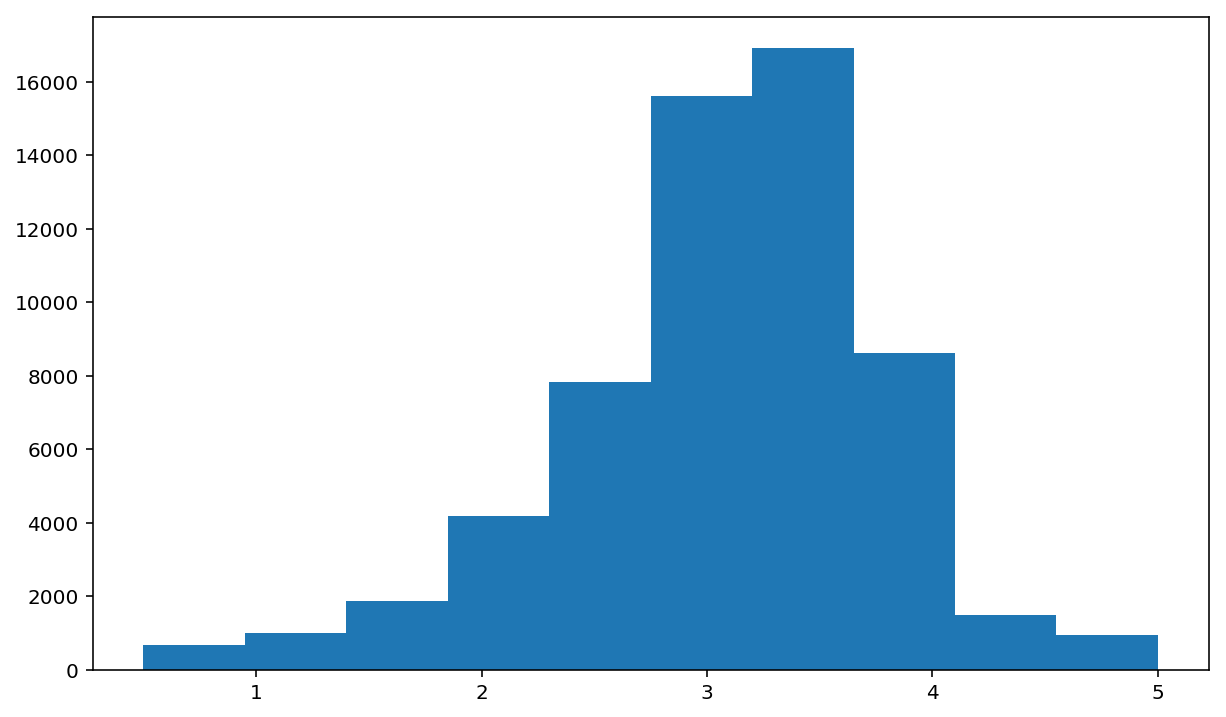

In [27]:
f, ax = plt.subplots(figsize=(10, 6))
plt.hist(avg_rating)
plt.show()

### Распределение числа оценок для фильмов

Построить распределение фильмов по числу оценок

In [28]:
rating_count = movie_rating_count.values().collect()

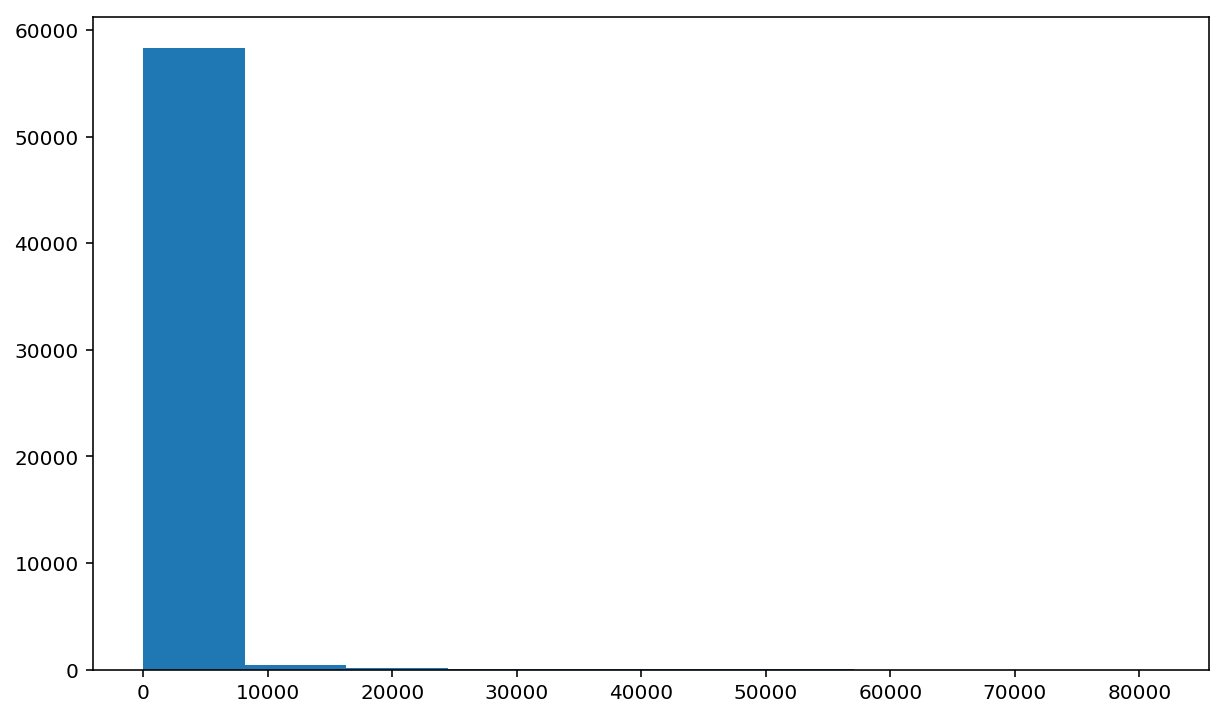

In [29]:
f, ax = plt.subplots(figsize=(10, 6))
plt.hist(rating_count)
plt.show()

### Распределение фильмов по жанрам

Построить гистограмму распределения фильмов по жанрам. Обратите внимание, что у фильма может быть указано больше одного жанра.

In [30]:
movies_genres = sc\
    .textFile(MOVIES_PATH)\
    .map(lambda s: s.split(','))\
    .filter(lambda arr: arr[0].isdigit())\
    .flatMap(lambda it: it[2].split('|'))\
    .collect()

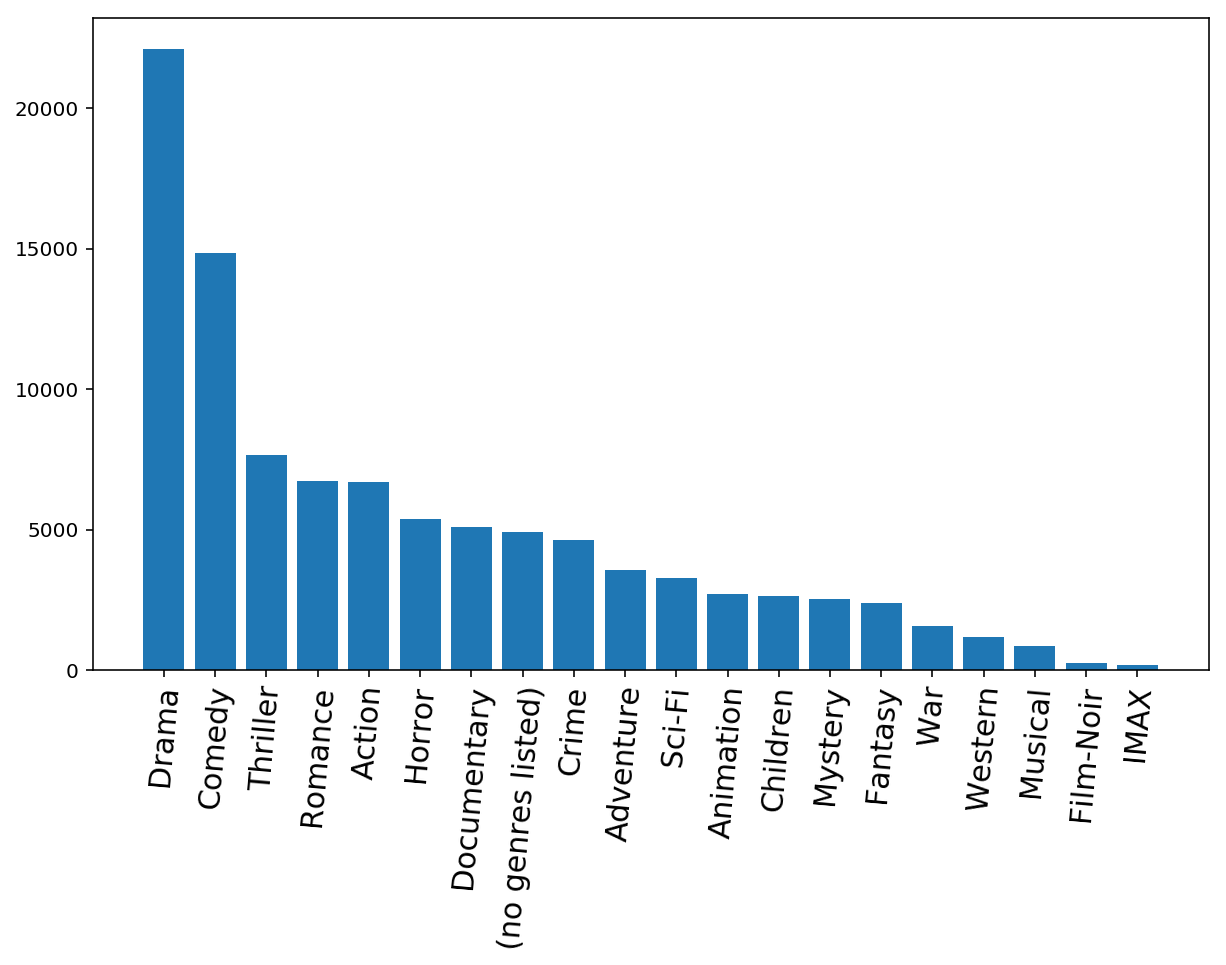

In [32]:
from collections import Counter


most_common_genres = Counter(movies_genres).most_common(20)
keys, values = zip(*most_common_genres)

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys, values, align="center")
plt.show()

### Актеры

Для решения задач ниже нужно воспользоваться файлами `ratings.csv`, `movies.csv`, `links.csv` и `tmdb.json`.

* `links.csv` - задает отображение из `movie_id` в `tmdb_movie_id` (подробное описание в `ml-25m-README.htm`)
* `tmdb.json` - содержит большое количество данных о фильмах в формате json (на каждой строчке отдельный json)

Задачи

1. Найти все фильмы, в которых играл `"id":31, "name":"Tom Hanks"`
2. Найти 10 актеров снявшихся в наибольшем числе фильмов. Вывести их имена и кол-во фильмов, в которых они снимались

In [33]:
import json


def get_list_of_casts(movie_info):
    movie_info = json.loads(movie_info)
    
    if 'id' in movie_info:    
        info_id = movie_info['id']
        casts = movie_info['casts']['cast']
        return [(info_id, (cast['id'], cast['name'])) for cast in casts]
    
    return []

In [34]:
links = sc\
    .textFile(os.path.join(DATA_PATH, 'links.csv'))\
    .map(lambda s: s.split(','))\
    .filter(lambda arr: arr[0].isdigit())\
    .filter(lambda arr: arr[2] != '')\
    .map(lambda arr: (int(arr[0]), int(arr[2])))

In [35]:
inverted_links = links.map(lambda it: (it[1], it[0]))

In [36]:
tmbd = sc\
    .textFile(os.path.join(DATA_PATH, 'tmdb.json'))\
    .flatMap(get_list_of_casts)

In [37]:
# tmdb_id, movie_id
inverted_links.take(3)

[(862, 1), (8844, 2), (15602, 3)]

In [38]:
# tmdb_id, (cast_id, cast_name)
tmbd.take(3)

[(862, (31, 'Tom Hanks')),
 (862, (12898, 'Tim Allen')),
 (862, (7167, 'Don Rickles'))]

In [39]:
# movie_id, (cast_id, cast_name)
casts = inverted_links.join(tmbd).values()

#### Задача 1

In [40]:
tom_hanks = casts.filter(lambda it: it[1][0] == 31)

movies_with_tom_hanks = movies\
    .join(tom_hanks)\
    .map(lambda it: it[1][0][1])\
    .collect()

print(movies_with_tom_hanks[:3])

['Sleepless in Seattle (1993)', '"Celluloid Closet', '"\'burbs']


In [41]:
len(movies_with_tom_hanks)

76

#### Задача 2

In [42]:
casts_names = casts.map(lambda it: it[1][1]).collect()

In [43]:
Counter(casts_names).most_common(10)

[('Bess Flowers', 380),
 ('Frank Welker', 184),
 ('Christopher Lee', 175),
 ('Clarence Nash', 158),
 ('Irving Bacon', 152),
 ('John Carradine', 146),
 ('John Wayne', 142),
 ('Mel Blanc', 140),
 ('Samuel L. Jackson', 134),
 ('Eric Roberts', 133)]

### Доля жанра в течении времени

Для каждого жанра нужно построить как менялась доля вышедших фильмов данного жанра относительно всех остальных жанров.

Дату выхода фильма можно взять из файла `tmdb.json`.

(См. `plt.stackplot`)

In [65]:
def get_movie_year(movie_info):
    movie_info = json.loads(movie_info)
    
    try:
        info_id = movie_info['id']
        date = int(movie_info['release_date'].split('-')[0])
        return (info_id, date)
    except:
        return []

In [66]:
release_years = sc\
    .textFile(os.path.join(DATA_PATH, 'tmdb.json'))\
    .map(get_movie_year)\
    .filter(lambda it: it != [])

In [67]:
# tmdb_id, year
release_years.take(3)

[(862, 1995), (8844, 1995), (15602, 1995)]

In [68]:
# movie_id, year
movie_year = inverted_links\
    .join(release_years)\
    .values()

In [69]:
movies_genres = sc\
    .textFile(MOVIES_PATH)\
    .map(lambda s: s.split(','))\
    .filter(lambda arr: arr[0].isdigit())\
    .flatMap(lambda it: [(int(it[0]), genre) for genre in it[2].split('|')])

# movie_id, genre
movies_genres.take(3)

[(1, 'Adventure'), (1, 'Animation'), (1, 'Children')]

In [70]:
# genre, year
genres = movies_genres\
    .join(movie_year)\
    .values()

genres.take(3)

[('Comedy', 2015), ('Horror', 2015), ('Comedy', 2017)]

In [71]:
# (year, genre), count
year_genre = genres\
    .map(lambda it: ((it[1], it[0]), 1))\
    .reduceByKey(lambda a, b: a + b)

year_genre.take(3)

[((2001, 'Documentary'), 77),
 ((2008, ' The (Beste Gegend) (2008)"'), 1),
 ((2004, " The (Conseguenze dell'amore"), 1)]

In [72]:
# Take top 20 genres
year_genre = year_genre.filter(lambda it: it[0][1] in keys)

In [73]:
years = year_genre.map(lambda it: it[0][0]).collect()
years = sorted(set(years))
year_to_index = {year: index for year, index in zip(years, range(len(years)))}

In [74]:
genres = year_genre.map(lambda it: it[0][1]).collect()
genres = sorted(set(genres))
genre_to_index = {genre: index for genre, index in zip(genres, range(len(genres)))}

In [75]:
import numpy as np


data = np.zeros(shape=(len(genres), len(years)))

for ((year, genre), cnt) in year_genre.collect():
    data[genre_to_index[genre], year_to_index[year]] = cnt

In [76]:
data /= data.sum(axis=0)

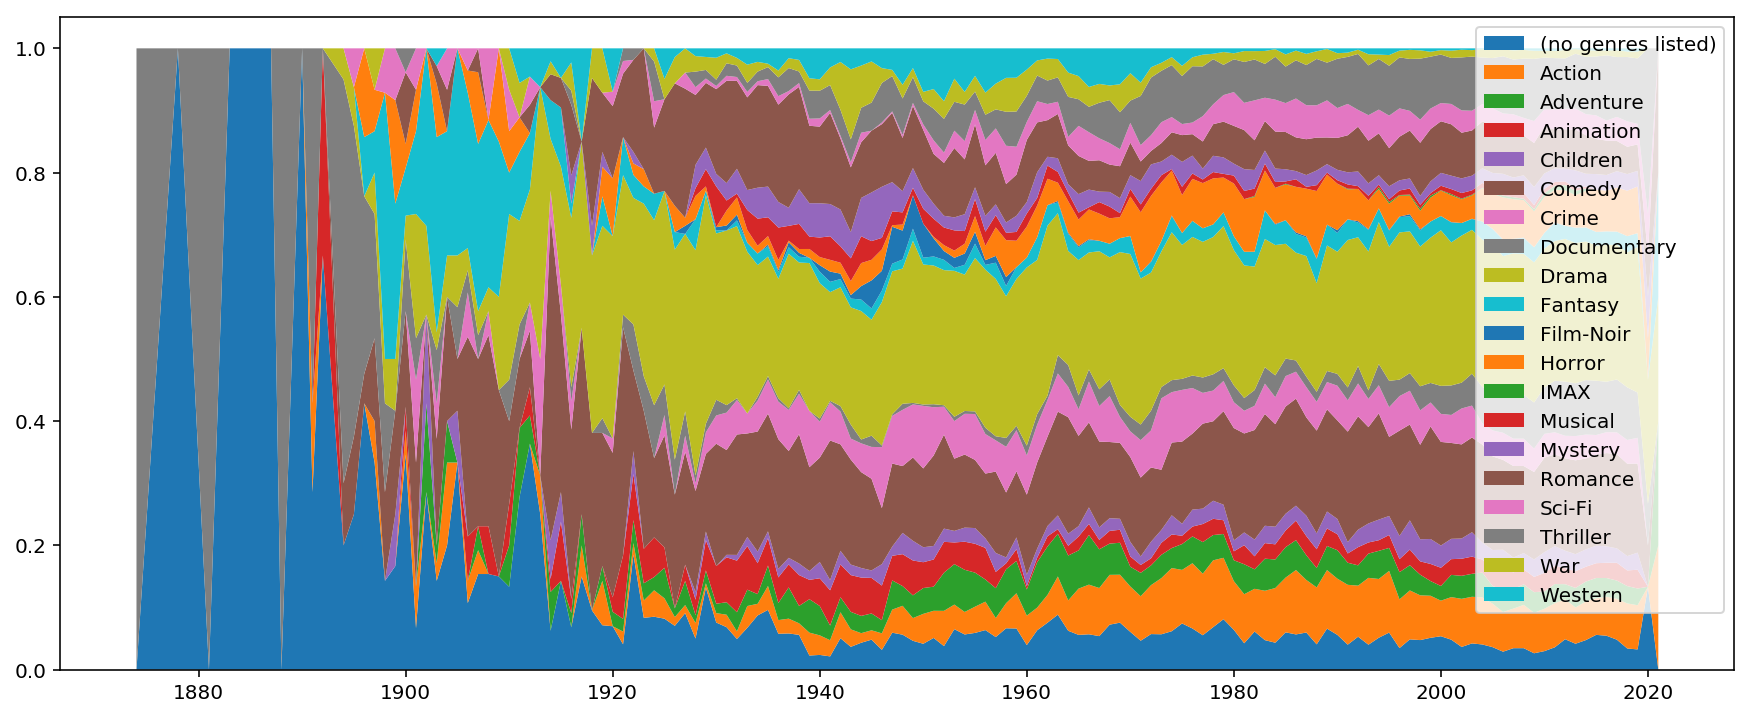

In [77]:
f, ax = plt.subplots(figsize=(15, 6))
plt.stackplot(years, data);
plt.legend(genres)
plt.show()

### Окупаемость фильмов

Для каждого жанра посчитать `ROI = mean(revenue) / mean(budget)` и построить `barplot`, где по оси x будет название жанра, а по оси y - `ROI`

Данные о `revenue` и `budget` можно найти в файле `tmdb.json`.

In [78]:
def get_movie_budget_and_revenue(movie_info):
    movie_info = json.loads(movie_info)
    
    try:
        info_id = movie_info['id']
        budget = int(movie_info['budget'])
        revenue = int(movie_info['revenue'])
        return (info_id, (budget, revenue))
    except:
        return []

In [79]:
budget_and_revenue = sc\
    .textFile(os.path.join(DATA_PATH, 'tmdb.json'))\
    .map(get_movie_budget_and_revenue)\
    .filter(lambda it: it != [])

# tmdb_id, (budget, revenue)
budget_and_revenue.take(3)

[(862, (30000000, 373554033)), (8844, (65000000, 262797249)), (15602, (0, 0))]

In [80]:
# movie_id, year
movie_budget_and_revenue = inverted_links\
    .join(budget_and_revenue)\
    .values()

movie_budget_and_revenue.take(3)

[(139735, (0, 0)), (147308, (0, 0)), (174261, (0, 0))]

In [81]:
movie_budget_and_revenue.take(10)

[(139735, (0, 0)),
 (147308, (0, 0)),
 (174261, (0, 0)),
 (8921, (0, 0)),
 (923, (839727, 23217674)),
 (6770, (0, 9726954)),
 (148805, (100000, 0)),
 (159692, (0, 0)),
 (206785, (0, 0)),
 (40278, (72000000, 96889998))]

In [82]:
# Remove trash
top_genres = movies_genres\
    .map(lambda it: (it[1], 1))\
    .reduceByKey(lambda a, b: a + b)\
    .filter(lambda it: it[1] > 100)\
    .keys()\
    .collect()

top_genres = sorted(set(top_genres))

In [83]:
genre_roi = movies_genres\
    .join(movie_budget_and_revenue)\
    .values()\
    .filter(lambda it: it[0] in top_genres)\
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))\
    .map(lambda it: (it[0].lower(), it[1][1] / it[1][0]))\
    .collect()

In [84]:
genre_roi

[('action', 2.8243017725643846),
 ('horror', 2.7184367531062668),
 ('western', 1.7005992708498678),
 ('imax', 3.500536723269289),
 (' the (2009)"', 3.3484581530238544),
 ('mystery', 2.5279238282601217),
 ('musical', 3.2291805348651033),
 ('fantasy', 3.017755955091183),
 (' the (2011)"', 2.7297717870810505),
 ('thriller', 2.542842086345313),
 ('children', 3.1525729476538134),
 ('(no genres listed)', 2.2612726567785537),
 ('romance', 3.0615697733587797),
 ('documentary', 2.9009406716372594),
 ('sci-fi', 3.0325607958623046),
 ('war', 2.077266345117479),
 ('animation', 3.605589236338009),
 ('film-noir', 1.7993130556242418),
 ('comedy', 2.9283290450712545),
 ('drama', 2.371219242275287),
 (' the (2012)"', 3.6048633780777455),
 ('adventure', 3.2353774983513284),
 ('crime', 2.344101387078034)]

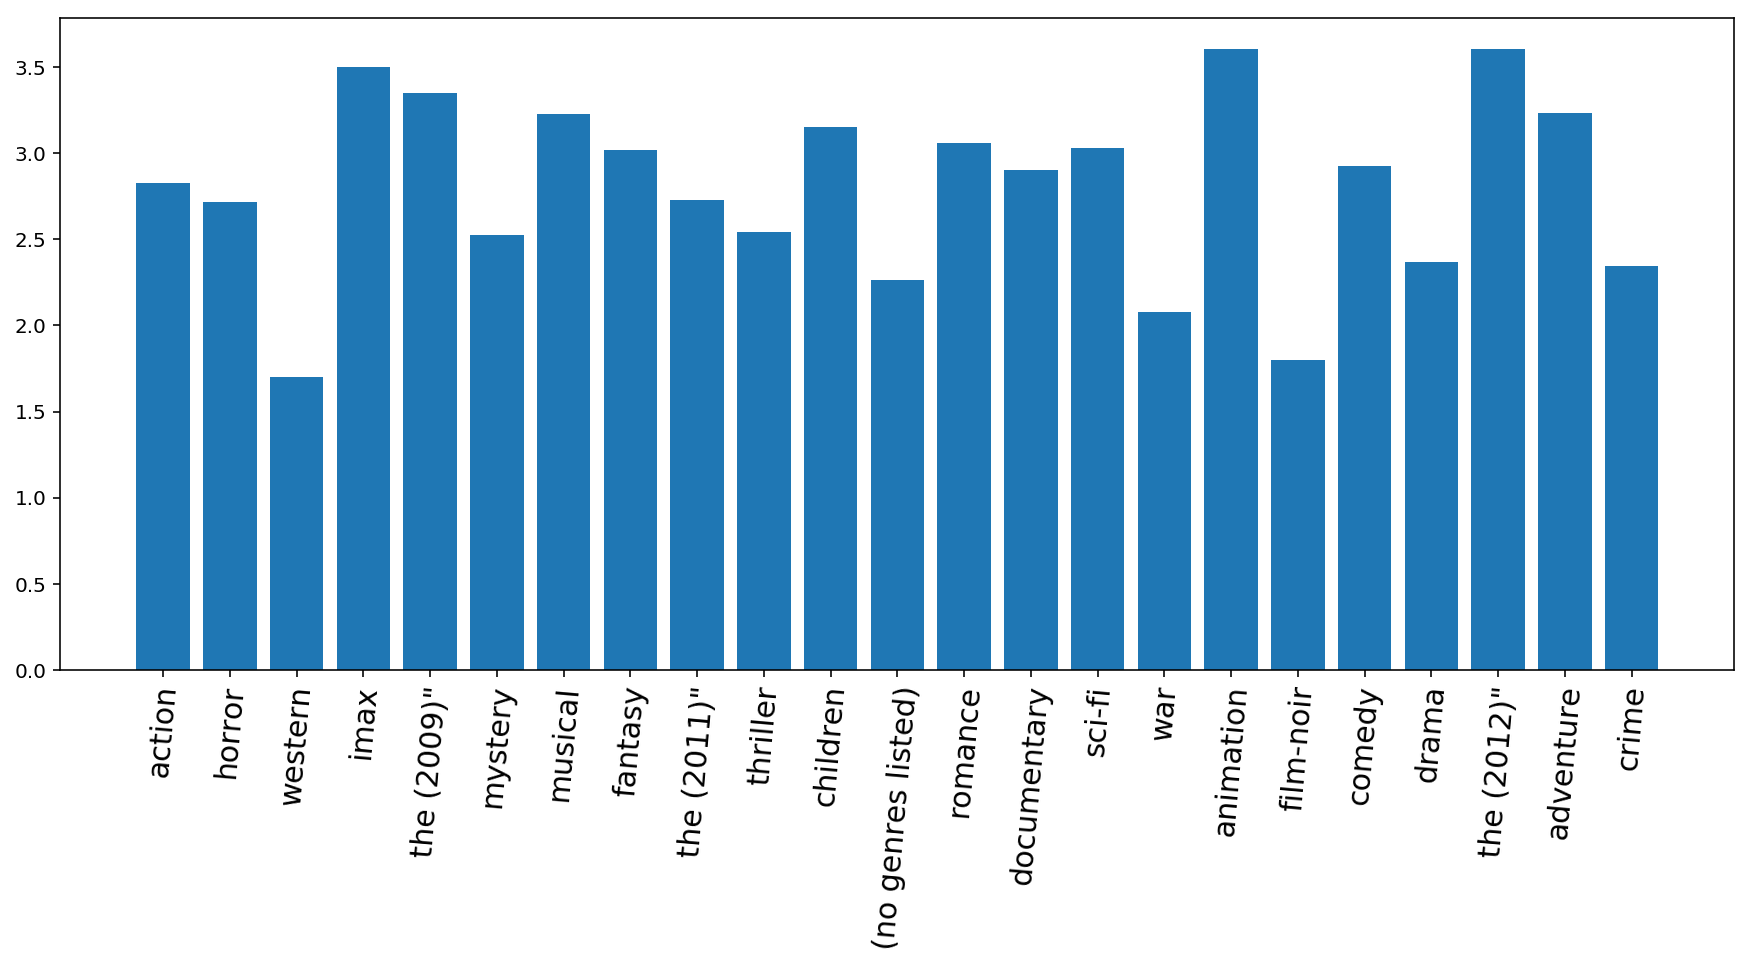

In [85]:
keys, values = zip(*genre_roi)

f, ax = plt.subplots(figsize=(15, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys, values, align="center")
plt.show()